## Notebook to analyze TH AV_Col27a1
Thalamus medium large sized subclass group. Seems to label anteroventral thalamus. Not much luck resolving clusters w/ ISH

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig

# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# TH MH_Tac2 is a medium large sized subclass within dataset
gluTypes = gluData.obs.subclass_label.unique()
gluCounts = pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], columns= ["Count"], index = gluTypes)
gluCounts = gluCounts.sort_values(by = "Count", ascending=False)
gluCounts

,Count
TH Prkcd_Grin2c,23362
TH_Rxfp1_Epb4,10411
TH PVT_Ntrk1,5419
TH/HY Gbx2 Zim1,5006
TH MH_Tac2,4405
TH AV_Col27a1,3011
TH PF_Fzd5,2500
TH LH_Pou4f1_Sox1,1346
TH Tfap2d,774
TH Serpinb7,398


In [5]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "TH AV_Col27a1"
genesRanked = pd.DataFrame(
        {key: gluData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False)
genesRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Col27a1,0.0,90.161331,12.079406,0.985387,0.052042,0.933345
1,Itga4,0.0,89.684525,9.909641,0.993026,0.199514,0.793512
2,Dpy19l1,0.0,87.517357,8.038668,0.998672,0.411196,0.587475
3,Ndrg1,0.0,86.295418,7.719673,0.998672,0.427525,0.571147
4,Npsr1,0.0,85.527733,12.525948,0.960810,0.106439,0.854371
...,...,...,...,...,...,...,...
23426,Enc1,0.0,-81.623711,-7.697086,0.343740,0.933673,-0.589934
23427,Zfp462,0.0,-81.785065,-10.455441,0.066423,0.895254,-0.828831
23428,Negr1,0.0,-84.141739,-4.255805,0.974427,0.998527,-0.024100
23429,Nlgn1,0.0,-84.274170,-4.954918,0.927931,0.993262,-0.065331


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'TH AV_Col27a1 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

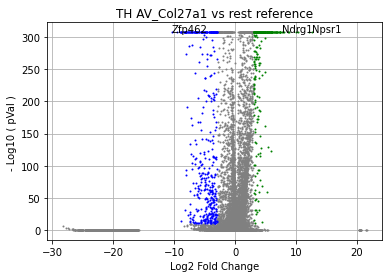

In [11]:
# Create volcano plot
plotVolcano(gluData,indx,label=["Npsr1","Zfp462","Ndrg1"])

In [25]:
# Take top 500 "score" genes
genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
genesFiltered = genesRanked.iloc[0:500,:]
genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
genesFiltered.head(20)

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Col27a1,0.0,90.161331,12.079406,0.985387,0.052042,0.933345
4,Npsr1,0.0,85.527733,12.525948,0.960810,0.106439,0.854371
1,Itga4,0.0,89.684525,9.909641,0.993026,0.199514,0.793512
6,Trpm6,0.0,84.949493,8.831781,0.983394,0.265914,0.717480
19,Zbtb16,0.0,76.855347,7.375628,0.947858,0.238485,0.709373
98,C1ql3,0.0,58.363853,7.381303,0.984391,0.279776,0.704614
36,Car4,0.0,70.044403,6.885489,0.959482,0.257796,0.701686
22,Myo5c,0.0,76.099823,7.062122,0.928263,0.229005,0.699258
48,Nrtn,0.0,65.217720,6.511682,0.820990,0.130518,0.690472
56,Klhl14,0.0,63.942200,7.822056,0.737961,0.064559,0.673401


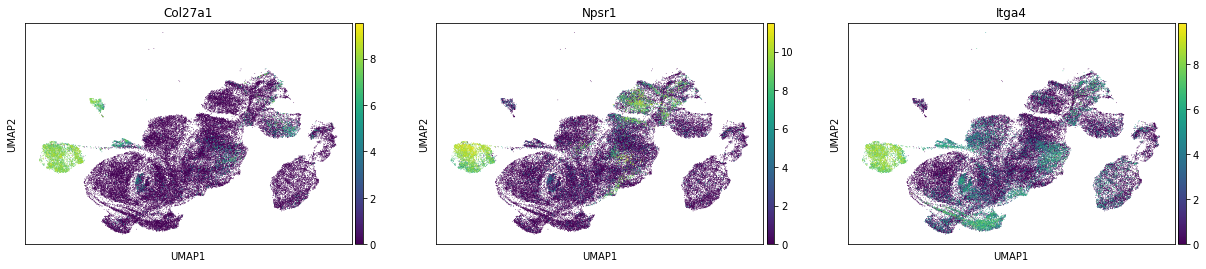

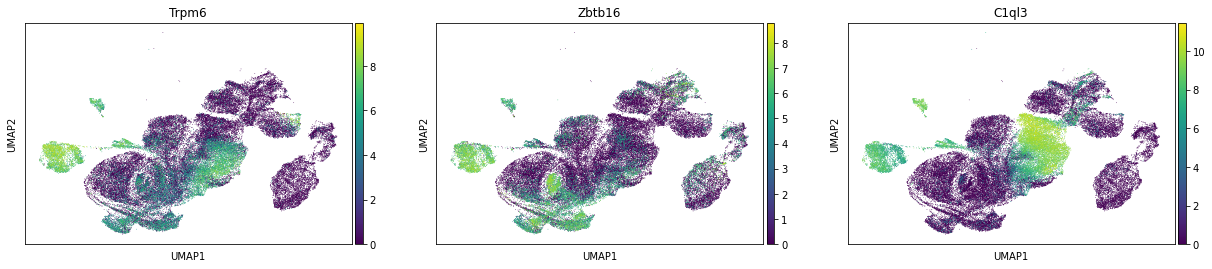

In [26]:
# Plot expression of several potential marker genes
# These genes are highly expressed in MH, but not elsewhere
sc.pl.umap(gluData, color = genesFiltered["names"][0:3])
sc.pl.umap(gluData, color = genesFiltered["names"][3:6])

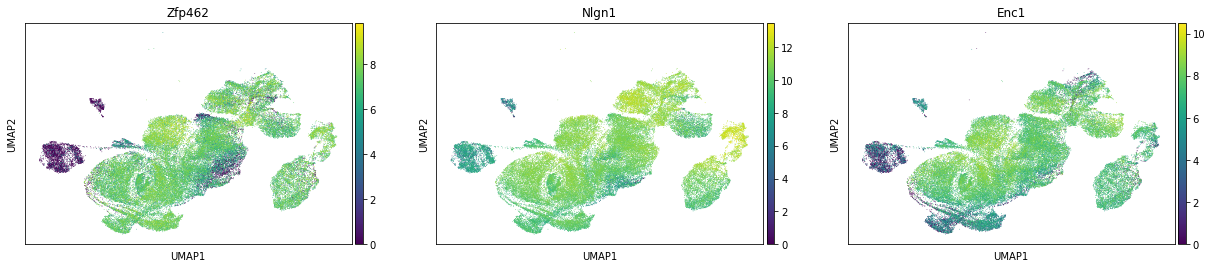

In [14]:
# Plot expression of several genes which are expressed elsewhere, but not MH
sc.pl.umap(gluData, color = ["Zfp462", "Nlgn1", "Enc1"])

In [27]:
# Look at marker gene overlap
markerGenes = {
    'TH AV_Col27a1' : genesFiltered["names"][:5].tolist(),
    'Downregulated' : genesFiltered["names"][-5:].tolist(),
    'TH Serpinb7' : ["C1ql2", "Stk32b", "Scn7a", "Megf11"],
}
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", top_n_markers=50, inplace=False)
markerOverlap

,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
TH AV_Col27a1,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Downregulated,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TH Serpinb7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


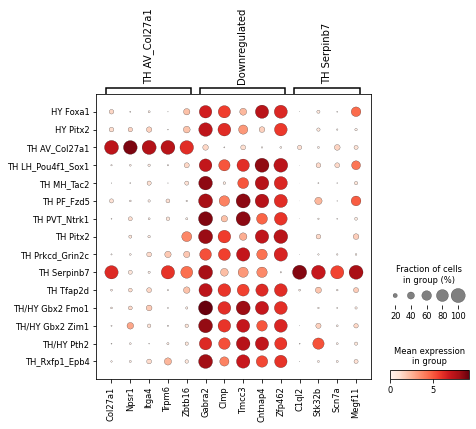

In [28]:
# Dotplot of marker gene expression in various groups
sc.pl.dotplot(gluData,markerGenes,"subclass_label", dendrogram = False)

In [57]:
clData.uns["rank_genes_groups"]
# markerGenes = {
#     'Upregulated' : clRanked["names"][:5].tolist(),
#     'Downregulated' :clRanked["names"][-5:].tolist(),
#     'Glut Cells' : ["Slc17a6", "Nrn1", "Cacna2d1", "Shox2", "Pcsk2"],
# }

# markerOverlap = sc.tl.marker_gene_overlap(clData,markerGenes,method="overlap_count", normalize= "reference",top_n_markers=50, inplace=False)
# markerOverlap

{'params': {'groupby': 'cluster_id',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':                     1941      1942      1944  1945
 gene                                              
 Xkr4            1.000000  1.000000  1.000000  1.00
 Rp1             0.069888  0.089744  0.053316  0.04
 Sox17           0.000743  0.000000  0.000650  0.00
 Mrpl15          0.740520  0.743590  0.661248  0.52
 Lypla1          0.017100  0.000000  0.016905  0.02
 ...                  ...       ...       ...   ...
 AC168977.1      0.001487  0.012821  0.005852  0.02
 AC149090.1      0.997026  1.000000  0.998049  0.98
 CAAA01118383.1  0.395539  0.461538  0.358257  0.36
 Vmn2r122        0.000000  0.000000  0.000000  0.00
 CAAA01147332.1  0.002230  0.012821  0.000650  0.00
 
 [23431 rows x 4 columns],
 'pts_rest':                     1941      1942      1944      1945
 gene                                                  
 Xk

## TH AV_Col27a1 subcluster analysis
Look at how the 4 clusters within the Col27a1 subclass differ

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


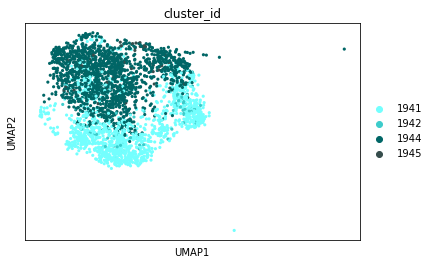

In [14]:
# Index by cell class
indx = "TH AV_Col27a1"
clData = gluData[gluData.obs.subclass_label == indx]
color_dict = dict(zip(clData.obs["cluster_id"],clData.obs["cluster_color"]))
sc.pl.umap(clData, color="cluster_id",palette=color_dict)

In [15]:
# Get counts of each cluster type
clTypes = clData.obs.cluster_id.unique()
clCounts = pd.DataFrame([sum(clData.obs.cluster_id == name) for name in clTypes], columns= ["Count"], index = clTypes)
clCounts = clCounts.sort_values(by = "Count", ascending=False)
clCounts

,Count
1944,1538
1941,1345
1942,78
1945,50


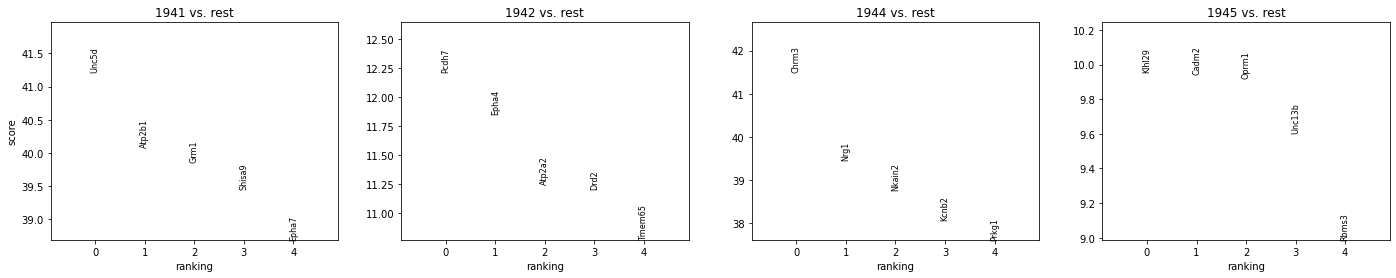

In [16]:
# Look for differential expression between clusters
sc.tl.rank_genes_groups(clData, 'cluster_id', method='wilcoxon', pts=True)
sc.pl.rank_genes_groups(clData, n_genes=5, sharey=False)

In [21]:
# Create a dataframe with list of gene scores, pvals, logfoldchanges, percentage expression
indx = "1944"
clRanked = pd.DataFrame(
        {key: clData.uns["rank_genes_groups"][key][indx]
        for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
pts = clData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
pts_rest = clData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
clRanked = pd.concat([clRanked, pts, pts_rest, pts_diff], axis=1)
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clRanked

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
0,Chrm3,0.0,41.491634,3.035607,0.985046,0.985743,-0.000698
23430,Grm1,0.0,-40.508915,-2.662021,0.394018,0.522064,-0.128046
23429,Unc5d,0.0,-40.066555,-6.438946,0.908322,0.948405,-0.040082
23428,Atp2b1,0.0,-39.950123,-1.218666,0.981795,0.966735,0.015060
23427,Shisa9,0.0,-39.628456,-5.399892,0.054616,0.078751,-0.024134
...,...,...,...,...,...,...,...
10579,Spin2e,1.0,0.000000,0.000000,0.001300,0.002037,-0.000736
10578,Btbd35f25,1.0,0.000000,0.000000,0.002601,0.007468,-0.004867
10577,Btbd35f22,1.0,0.000000,0.000000,0.003901,0.002716,0.001186
10576,Btbd35f2,1.0,0.000000,0.000000,0.004551,0.001358,0.003194


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'1944 vs rest reference'}, xlabel='Log2 Fold Change', ylabel='- Log10 ( pVal ) '>)

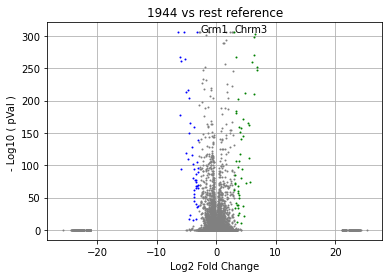

In [22]:
# Query volcano plots for various clusters
plotVolcano(clData,indx)

In [23]:
# Take top 500 "score" genes, filtered out for atleast 2 logfold change
clRanked = clRanked.sort_values(by=["scores"], ascending=False, key=abs)
clFiltered = clRanked.iloc[0:500,:]
clFiltered = clFiltered[clFiltered["logfoldchanges"] > abs(2)]
clFiltered = clFiltered.sort_values(by=["pts_diff"], ascending=False)
clFiltered.head(10)

,names,pvals,scores,logfoldchanges,pts,pts_rest,pts_diff
102,Grp,3.277748e-76,18.475075,5.692469,0.962939,0.875764,0.087175
4,Prkg1,1.067302e-309,37.618603,2.786151,0.998049,0.921928,0.076121
97,Ass1,1.139786e-80,19.021139,2.383688,0.962939,0.919891,0.043048
84,Jam2,4.511826e-92,20.351402,2.960398,0.905072,0.864902,0.040170
148,Rgs10,1.460896e-59,16.276011,3.586775,0.971391,0.944331,0.027060
6,Kcnq5,1.106709e-301,37.125084,6.370272,0.996099,0.970129,0.025970
121,Col12a1,2.407550e-70,17.731220,3.603755,0.760078,0.745418,0.014661
125,Abca8b,3.400944e-68,17.450691,2.089706,0.980494,0.966735,0.013760
58,Cygb,8.481911e-124,23.663942,2.015479,0.952536,0.940937,0.011599
1,Nrg1,0.000000e+00,39.464569,2.613870,0.997399,0.988459,0.008940


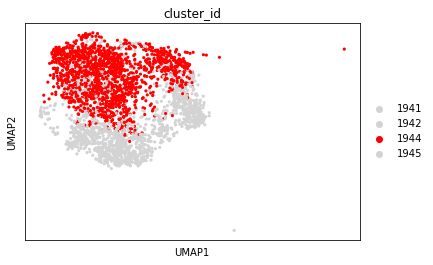

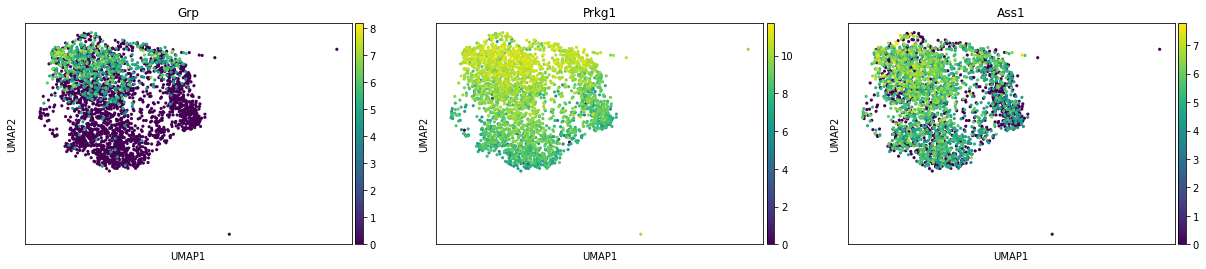

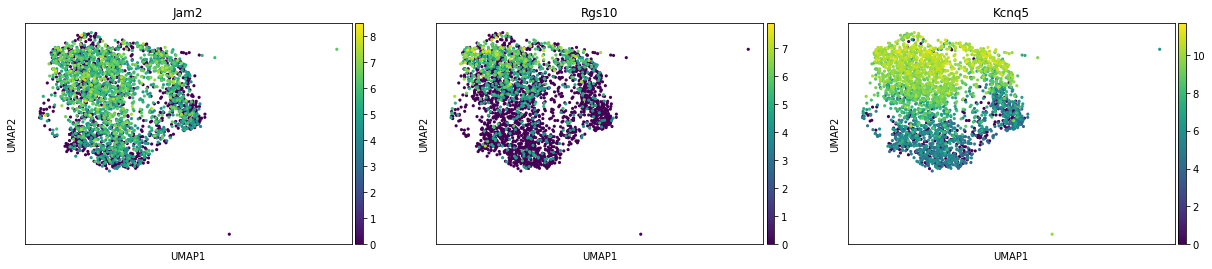

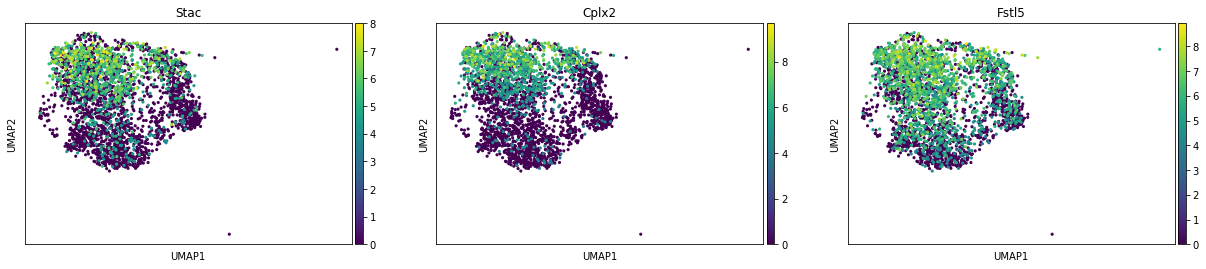

In [24]:
# Plot expression of several potential marker genes
maskPalette = create_mask_dict(clData.obs.cluster_id.unique(),indx)
sc.pl.embedding(clData, "umap", color = "cluster_id", palette=maskPalette)

sc.pl.umap(clData, color = clFiltered["names"][0:3])
sc.pl.umap(clData, color = clFiltered["names"][3:6])
sc.pl.umap(clData, color = clFiltered["names"][-3:])

## Other stuff

In [ ]:
# Link to Allen ISH
# Col27a1, seems to label Anterodorsal, anteroventral, anteromedial, anterior edge of anterolateral, 
# and perhaps lightly label parafasicular nucleus
https://mouse.brain-map.org/experiment/show/74272916

# Nspr1, seems to label anterior paraventricular, anteroventral and (lightly) anterodorsal, 
https://mouse.brain-map.org/experiment/show/70560288

# Itga4, seems to specifically label anteroventral, maybe anterodorsal
https://mouse.brain-map.org/experiment/show/77924520

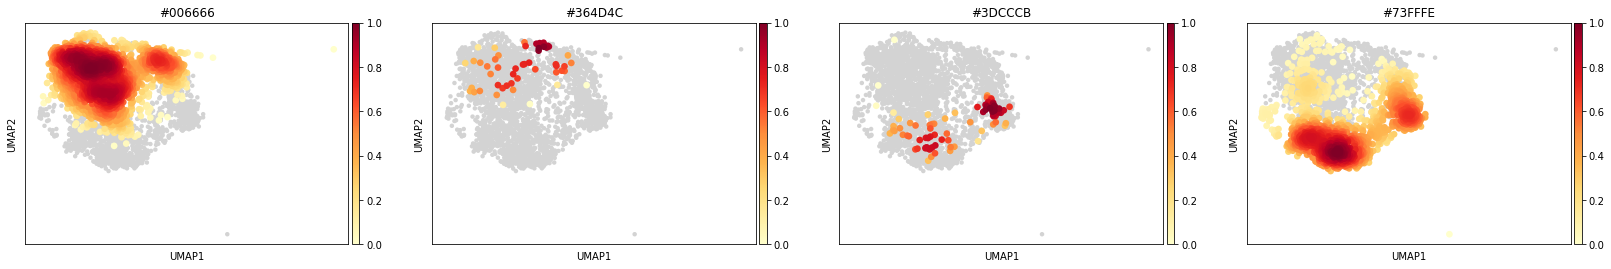

In [23]:
# Embedding densitt key seems to break down for fully numeric names, grouping by cluster color seems to work though
sc.tl.embedding_density(clData, basis="umap",groupby="cluster_color")
sc.pl.embedding_density(clData, basis="umap", key="umap_density_cluster_color")

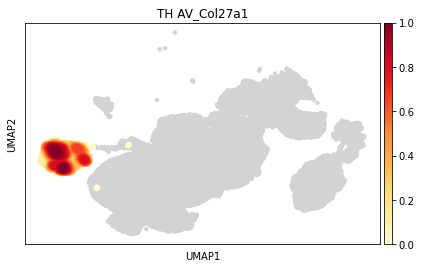

In [26]:
sc.tl.embedding_density(gluData, basis="umap", groupby="subclass_label")
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label", group=indx)